# Part 2 - Data Wrangling
---
### Papers Past Topic Modeling

<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import sys, subprocess
sys.path.insert(0, '../utils')
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)
from pyspark.sql import functions as F
from pyspark.sql.types import *
from utils import conf_pyspark, load_dataset
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
# intiate PySpark
sc, spark = conf_pyspark()

sc

[('spark.driver.port', '41465'),
 ('spark.driver.host', 'x99.hub'),
 ('spark.app.name', 'local'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1548157548578'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.memory', '62g'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.cores', '6'),
 ('spark.driver.maxResultSize', '4g')]


<SparkContext master=local[*] appName=local>

## 1 Load Data

**Load raw dataset:**

In [3]:
df = load_dataset('papers_past', spark)

In [4]:
nrow_raw = df.count()
print('Shape of dataframe: ({}, {})'.format(nrow_raw, len(df.columns)))
df.sample(False, 0.00001).limit(10).toPandas().head(10)

Shape of dataframe: (16731578, 6)


,id,url,publisher,time,title,content
0,2838876,http://api.digitalnz.org/records/2838876/source,Timaru Herald,1864-07-30T00:00:00.000Z,"Page 5 Advertisements Column 3 (Timaru Herald, 30 July 1864)","New Advertisements. /CLARKSON & TURNBULL, IMPORTERS DIRECT FROM ENGLAND, South Road and George-street, Timaru. rpO A..."
1,34233858,http://api.digitalnz.org/records/34233858/source,Mataura Ensign,1912-02-29T12:00:00Z,NEVER WAITS. (Mataura Ensign 29-2-1912),"NEVER WAITS.""I never wait until my children are bad with colds or croup but give them Chamberlain's Cough Remedy as ..."
2,29021537,http://api.digitalnz.org/records/29021537/source,Daily Telegraph,1889-07-05T00:00:00.000Z,"LATE CABLES (Daily Telegraph, 05 July 1889)","LATE CABLES[I'ER I'RICSS ASSOCIATION. —COPYRIGHT.] (Received July 5, 2 p.m.) TERRIBLE MINING DISASTER. London, July ..."
3,27247854,http://api.digitalnz.org/records/27247854/source,Ellesmere Guardian,1935-06-18T00:00:00.000Z,"SIGHT RESTORED. (Ellesmere Guardian, 18 June 1935)","SIGHT RESTORED.TRIUMPH OF SURGERY.(Fr«m the Guardian's Special Corres-pondent—By Air Mail)PARIS, May 25After 18 year..."
4,2495073,http://api.digitalnz.org/records/2495073/source,Bay Of Plenty Times,1885-09-08T00:00:00.000Z,"TO-MORROW'S ECLIPSE. (Bay Of Plenty Times, 08 September 1885)","TO-MORROW'S ECLIPSE.Toricoitifow, September 9, a total eclipse of the sun will occur. The Hue of totality, or path o..."
5,11372834,http://api.digitalnz.org/records/11372834/source,North Otago Times,1893-12-16T00:00:00.000Z,"CHIRISTCHCRCH. December 14. (North Otago Times, 16 December 1893)",CHIRISTCHCRCH. December 14.Tho Ohiistchurcli Mister Tail >r«' and Cutters* Association hive resolved to wind up owin...
6,4230703,http://api.digitalnz.org/records/4230703/source,North Otago Times,1875-12-18T00:00:00.000Z,"Page 5 Advertisements Column 2 (North Otago Times, 18 December 1875)",New Advertisements. OTEPOPO ATHENJEUM. A SOCIAL GATHERING in aid ■^ of the Presbyterian Church Fund will be held in ...
7,5795844,http://api.digitalnz.org/records/5795844/source,North Otago Times,1878-02-09T00:00:00.000Z,"RAILWAY MANAGEMENT? (To the Editor of the North Otago Times ) (North Otago Times, 09 February 1878)","RAILWAY MANAGEMENT? (To the Editor of the North Otago Times )Sir,— A gient deal has been said of late about tho care..."
8,5975134,http://api.digitalnz.org/records/5975134/source,North Otago Times,1879-07-05T00:00:00.000Z,"North Otago Times. SATURDAY, JULY 5, 1879. (North Otago Times, 05 July 1879)","North Otago Times. SATURDAY, JULY 5, 1879.Tub Parliament of Now Zealand meets on Friday next for tho despatch of bus..."
9,11066834,http://api.digitalnz.org/records/11066834/source,Wanganui Herald,1895-01-23T00:00:00.000Z,"STOCK INSPECTORS' CONFERENCE. (Wanganui Herald, 23 January 1895)","STOCK INSPECTORS' CONFERENCE.(By Eleotrio Telegraph — Copyright.) (Per United Press Association.)Brisbane, January 2..."


## 2 Clean Data

### 2.1 Missing Values

**Check empty values:**

In [5]:
# Count null
print('Print Null:')
df.select([F.count(F.when(F.col(c).isNull() | (F.col(c) == ''), c))
           .alias(c) for c in df.columns]).show()

Print Null:
+---+---+---------+----+-----+-------+
| id|url|publisher|time|title|content|
+---+---+---------+----+-----+-------+
|  0|  0|        0|   0|    0|  56232|
+---+---+---------+----+-----+-------+



**Drop rows with empty document:**

In [5]:
# Clean NA to avoid nonetype.
df = df.na.drop(subset=['content'])

**Check again:**

In [7]:
# Count null
print('Print Null:')
df.select([F.count(F.when(F.col(c).isNull() | (F.col(c) == ''), c))
           .alias(c) for c in df.columns]).show()

Print Null:
+---+---+---------+----+-----+-------+
| id|url|publisher|time|title|content|
+---+---+---------+----+-----+-------+
|  0|  0|        0|   0|    0|      0|
+---+---+---------+----+-----+-------+



### 2.2 Duplicate Values

**The "id" should be unique, check duplication:**

In [8]:
print('Duplicated id number: ', df.count() - df.select('id').distinct().count())

Duplicated id number:  543700


**There are duplicated "id" in the dataset, show three of them:**

In [9]:
df.groupBy('id').count().where(F.col('count')>1).show(3)

+--------+-----+
|      id|count|
+--------+-----+
|11642926|    2|
|11651057|    2|
|11709006|    2|
+--------+-----+
only showing top 3 rows



**Select the first one to check detail:**

In [10]:
df.filter(df.id == 10036037).toPandas().head()

,id,url,publisher,time,title,content
0,10036037,http://api.digitalnz.org/records/10036037/source,Poverty Bay Herald,1898-01-06T00:00:00.000Z,"THE EASTERN SITUATION (Poverty Bay Herald, 06 January 1898)","THE EASTERN SITUATION'Octis"" in the Sydney Telogrnph delivers himself of this clever satire on the recent events in ..."
1,10036037,http://api.digitalnz.org/records/10036037/source,Poverty Bay Herald,1898-01-06T00:00:00.000Z,"THE EASTERN SITUATION (Poverty Bay Herald, 06 January 1898)","THE EASTERN SITUATION'Octis"" in the Sydney Telogrnph delivers himself of this clever satire on the recent events in ..."


**Check difference of the content:**

In [11]:
import difflib

str1 = df.filter(df.id == 10036037).select('content').collect()[0]['content']
#print(str1 + '\n')

str2 = df.filter(df.id == 10036037).select('content').collect()[1]['content']
#print(str2 + '\n')

diff = difflib.SequenceMatcher(None, str1, str2).ratio()

print('Similarity: ', diff)

Similarity:  0.9994846688997681


**The two duplicates are very close, drop one of them:**

In [6]:
df = df.drop_duplicates(subset=['id'])

**Check duplicate again:**

In [13]:
print('Duplicated id number: ', df.count() - df.select('id').distinct().count())

Duplicated id number:  0


### 2.3 Abnormal Values

**There should be 68 publishers, check numbers:**

In [14]:
n = df.select('publisher').distinct().count()
print(n)
if n == 68:
    print('Correct! no abnormal values in publishers.')
else:
    print('Error! abnormal values in publishers.')

68
Correct! no abnormal values in publishers.


### 2.4 Outlier

**Since short text would not contribute to topic modeling, we set a number as the minimum value, any content of a sample/document/row will regards as outlier and delete from dataset.**

In [7]:
# generate word counts of each document
df = df.withColumn('length', F.length('content'))

In [16]:
# convert pyspark dataframe column to list
length = list(
    df.select('length').toPandas()['length']
)

**General statistical plot:**

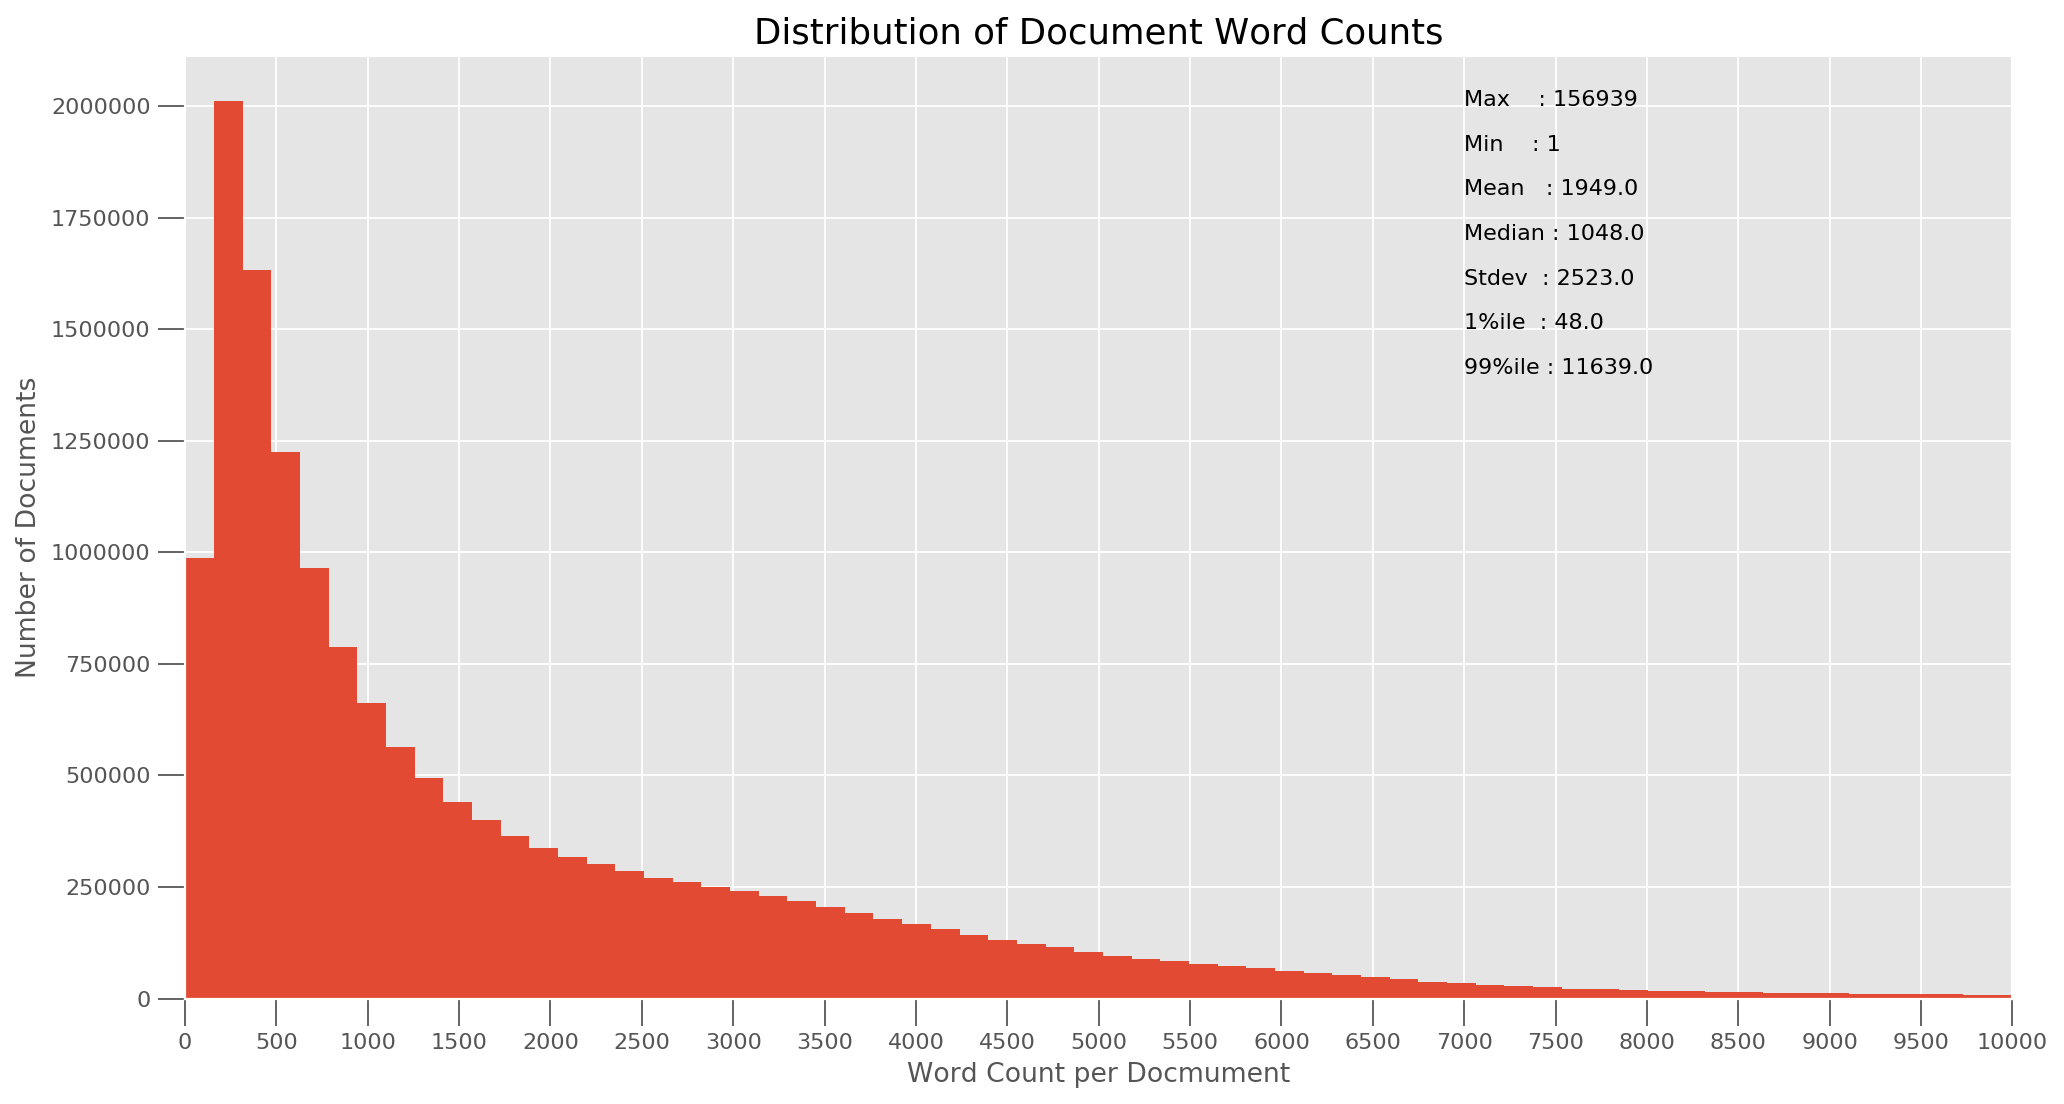

In [17]:
# Plot
plt.figure(figsize=(13,7), dpi=160)
plt.hist(length, bins = 1000)
plt.text(7000, 2000000, "Max    : " + str(round(np.max(length))))
plt.text(7000, 1900000, "Min    : " + str(round(np.min(length))))
plt.text(7000, 1800000, "Mean   : " + str(round(np.mean(length))))
plt.text(7000, 1700000, "Median : " + str(round(np.median(length))))
plt.text(7000, 1600000, "Stdev  : " + str(round(np.std(length))))
plt.text(7000, 1500000, "1%ile  : " + str(round(np.quantile(length, q=0.01))))
plt.text(7000, 1400000, "99%ile : " + str(round(np.quantile(length, q=0.99))))
plt.gca().set(xlim=(0, 10000), ylabel='Number of Documents', xlabel='Word Count per Docmument')
plt.tick_params(size=12)
plt.xticks(np.linspace(0,10000,21))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=16))
plt.tight_layout()
plt.show()

**Magnify the range of 0 to 1000 words:**

In [18]:
length1000 = [i for i in length if i <= 1000]

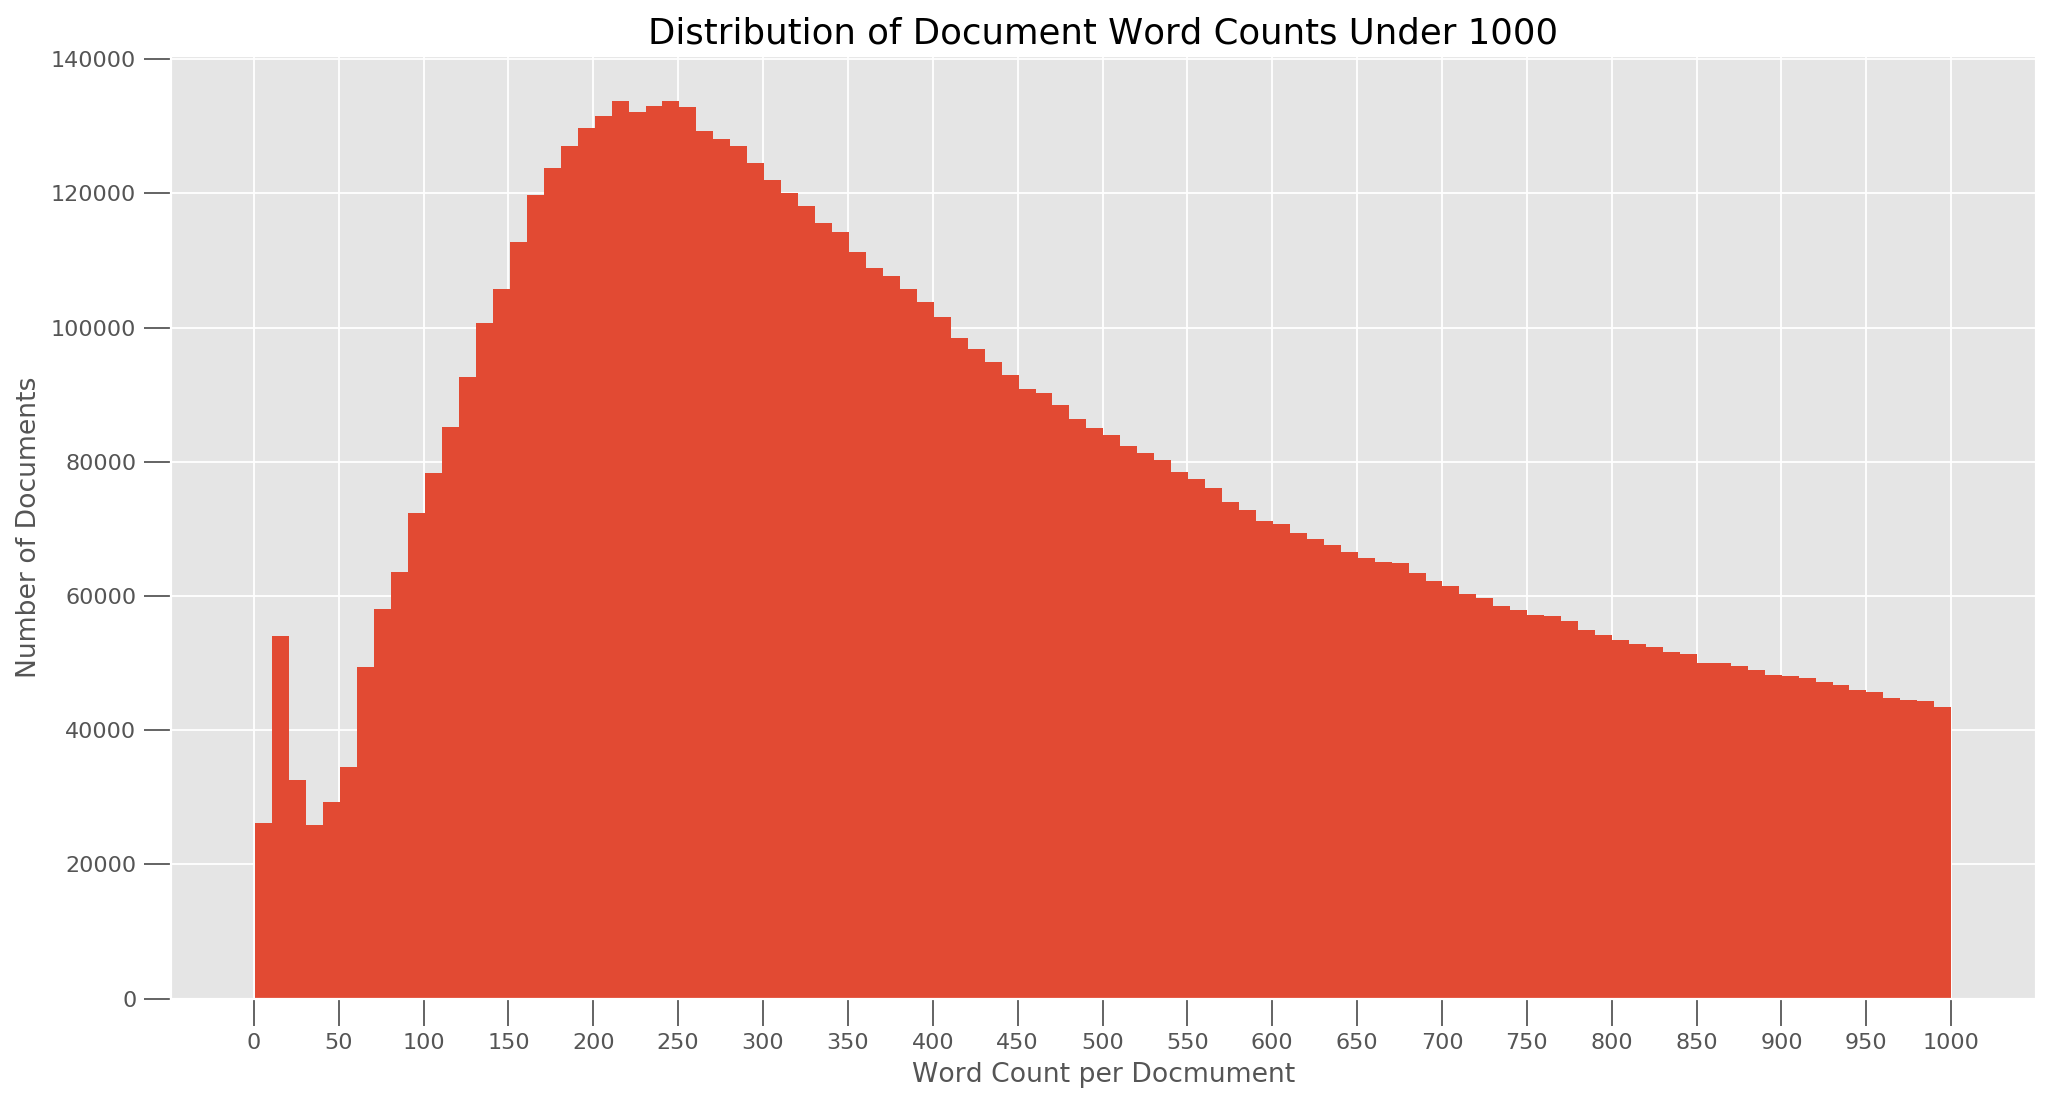

In [19]:
plt.figure(figsize=(13,7), dpi=160)
plt.hist(length1000, bins = 100)
plt.gca().set(ylabel='Number of Documents', xlabel='Word Count per Docmument')
plt.tick_params(size=12)
plt.xticks(np.linspace(0,1000,21))
plt.title('Distribution of Document Word Counts Under 1000', fontdict=dict(size=16))
plt.tight_layout()
plt.show()

**From above plots we see that the number of documents drop rapidly when word count is under 200, consider the the short text is not very useful for LDA algorithm, we set the lower limit of outlier to 160, which means we remove documents which word count is under 160.**


In [8]:
min_count = 160

# remove rows with length under min_count
df = df.filter(df.length >= min_count)

In [21]:
length_min = len([i for i in length if i < min_count])
length_all = len(length)

print('{} ({:.2f}%) samples/rows/documents were move out from dataset.'.format(length_min, 100*length_min/length_all))

1009676 (6.26%) samples/rows/documents were move out from dataset.


## 3 Extract Features

### 3.1 Date

**For history documents, it only need date as time unit, we extract "date" column from "time" column:**

In [9]:
# extract feature date
df = df.withColumn('date', df['time'].cast(DateType()))

**Check schema of the dataframe:**

In [23]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- url: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- time: string (nullable = true)
 |-- title: string (nullable = true)
 |-- content: string (nullable = true)
 |-- length: integer (nullable = true)
 |-- date: date (nullable = true)



**Check date range has abnormal values:**

In [24]:
start, end = df.select(F.min('date'), F.max('date')).first()
start, end

(datetime.date(1839, 8, 21), datetime.date(1945, 12, 31))

### 3.2 Advertisements

**Check "title" column to see if it is possible to extract features:**

In [25]:
df.sample(False, 0.00001).limit(10).select('id', 'date', 'title').toPandas().head(10)

,id,date,title
0,29575716,1913-07-03,"DO ALL CLAIMED. (Wairarapa Daily Times, 03 July 1913)"
1,4176294,1878-05-16,"Page 2 Advertisements Column 1 (Waikato Times, 16 May 1878)"
2,7655122,1908-05-01,"AHEAD OF THE TRAIN. (Bush Advocate, 01 May 1908)"
3,20059065,1896-09-28,"ANOTHER KHARPUT MASSACRE. EUROPE'S ATTITUDE TOWARDS ENGLAND. (Evening Post, 28 September 1896)"
4,18855005,1924-01-30,"SHORTT'S THEATRE. (Evening Post, 30 January 1924)"
5,7956998,1885-10-31,"SHIPPING INTELLIGENCE. (Taranaki Herald, 31 October 1885)"
6,4620542,1868-08-07,"Page 1 Advertisements Column 2 (Colonist, 07 August 1868)"
7,11108102,1890-09-19,"Colonial Bank. (Star, 19 September 1890)"
8,9683896,1876-03-21,"THE KNOX CHURCH BAZAAR. (Otago Daily Times, 21 March 1876)"
9,32799961,1916-09-11,Page 3 Advertisements Column 2 (Otago Daily Times 9-11-1916)


**The "title" column specified advertisements, we extract "ads" column from "title" column:**

In [10]:
# extract feature ads
df = df.withColumn('ads', df.title.contains('dvertisement'))

In [27]:
df.sample(False, 0.00001).limit(10).select('id', 'ads', 'title').toPandas().head(10)

,id,ads,title
0,29686971,False,"FATHER'S SAD DISCOVERY. (Wairarapa Daily Times, 01 June 1916)"
1,20280489,False,"How to Make Oyster Croquettes. (Bruce Herald, 09 November 1894)"
2,12612958,False,"South African Affairs (Southland Times, 29 October 1902)"
3,5254614,False,"FURTHER PAY-OUT (Evening Post, 04 December 1937)"
4,26995796,False,"IN MEMORIAM. (Northern Advocate, 26 November 1915)"
5,5009747,False,"Untitled (Observer, 23 February 1895)"
6,29799070,False,"A GREAT FAILURE. (Wairarapa Daily Times, 13 December 1919)"
7,23687013,False,"NEW ZEALAND IN LONDON. (Feilding Star, 05 May 1916)"
8,4847368,False,"DEATH. (Grey River Argus, 25 April 1877)"
9,28689359,False,"CRICKET IN AUSTRALIA. (Auckland Star, 28 January 1902)"


### 3.3 Title

**The title consists of three parts: "real title" ("publisher", "date"), we only need "real title" part. Extract real title:**

In [11]:
# remove redandunt parts of title
df = df.withColumn('title_', F.regexp_extract(F.col('title'), '(.*)(\s\(.*\))', 1))

**Check if some titles are not the form "title ("publisher", "date"), which will lead to "title_" column is empty string:**

In [29]:
df.where(F.col('title_') == '').select(['id', 'title_', 'title']).show(5, False)

+--------+------+---------------------+
|id      |title_|title                |
+--------+------+---------------------+
|3656781 |      |Untitled Illustration|
|4832017 |      |Untitled Illustration|
|5417742 |      |Untitled Illustration|
|12676570|      |Untitled Illustration|
|23484819|      |Untitled Illustration|
+--------+------+---------------------+
only showing top 5 rows



**Change empty string in "title_" column to "Untitled Illustration":**

In [12]:
df = df.withColumn(
    'title_',
    F.when(
        F.col('title_') == '',
        F.lit('Untitled Illustration')
    ).otherwise(
        F.col('title_')
    )
)

**Check empty string again:**

In [31]:
# Count null
print('Print Null:')
df.select([F.count(F.when(F.col(c).isNull() | (F.col(c) == ''), c))
           .alias(c) for c in df.columns]).show()

Print Null:
+---+---+---------+----+-----+-------+------+----+---+------+
| id|url|publisher|time|title|content|length|date|ads|title_|
+---+---+---------+----+-----+-------+------+----+---+------+
|  0|  0|        0|   0|    0|      0|     0|   0|  0|     0|
+---+---+---------+----+-----+-------+------+----+---+------+



**Print title columns:**

In [32]:
df.sample(False, 0.00001).limit(10).select('id', 'title_', 'title').toPandas().head(10)

,id,title_,title
0,28026778,THE INDUSTRIES EXHIBITION.,"THE INDUSTRIES EXHIBITION. (Auckland Star, 31 December 1884)"
1,33586528,FOOTBALL.,FOOTBALL. (Otago Daily Times 14-9-1901)
2,2462449,Page 7 Advertisements Column 1,"Page 7 Advertisements Column 1 (Bruce Herald, 04 June 1878)"
3,9776372,Island Bay Park R.C. Summer Meeting.,"Island Bay Park R.C. Summer Meeting. (Star, 23 January 1886)"
4,33572271,CITY POLICE COURT.,CITY POLICE COURT. (Otago Daily Times 17-4-1901)
5,2168592,Page 1 Advertisements Column 4,"Page 1 Advertisements Column 4 (Grey River Argus, 19 September 1868)"
6,9541213,The Temperature.,"The Temperature. (Wanganui Herald, 06 January 1891)"
7,29072792,Page 4 Advertisements Column 6,"Page 4 Advertisements Column 6 (Daily Telegraph, 27 October 1893)"
8,10172636,MAIL NOTICE.,"MAIL NOTICE. (North Otago Times, 16 July 1889)"
9,29772769,BURGLARS AT WORK.,"BURGLARS AT WORK. (Wairarapa Daily Times, 21 June 1918)"


### 3.4 Region

**In the website of [Papers Past](https://paperspast.natlib.govt.nz), we could find the publisher-region relationship in the [Explore all newspapers](https://paperspast.natlib.govt.nz/newspapers/all#region) webpage. Based on this webpage, we could extract region feature from "publisher" column. Here we saved [the webpage](https://paperspast.natlib.govt.nz/newspapers/all#region) and crawling the publisher-region relationship into a dataframe for extract feature.**

In [13]:
from bs4 import BeautifulSoup

# read webpage
path = r'../temp/Papers Past _ Explore all newspapers.html'
with open(path, 'r') as f:
    html = f.read()

# get table 
soup = BeautifulSoup(html, "html.parser")
table = soup.find('table', attrs={'class':'table datatable'})
table_rows = table.find_all('tr')
res = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        res.append(row)

# transform table to pandas dataframe
df_region = pd.DataFrame(res, columns=['publisher_', 'region', 'start_', 'end_']) # column_ means it will be drop later

# transform pandas dataframe to pyspark dataframe
df_region = spark.createDataFrame(df_region).orderBy('region')

In [34]:
print('Shape of dataframe: ({}, {})'.format(df_region.count(), len(df_region.columns)))
df_region.sample(False, 0.1).toPandas().head(10)

Shape of dataframe: (148, 4)


,publisher_,region,start_,end_
0,New Zealand Herald,Auckland,1863,1945
1,New Zealand Herald and Auckland Gazette,Auckland,1841,1842
2,Te Puke Times,Bay of Plenty,1913,1920
3,Ashburton Guardian,Canterbury,1879,1921
4,Globe,Canterbury,1874,1882
5,Lyttelton Times,Canterbury,1851,1914
6,North Canterbury Gazette,Canterbury,1932,1939
7,Matariki,Gisborne,1881,1881
8,Hastings Standard,Hawke's Bay,1896,1920
9,Hawke's Bay Herald,Hawke's Bay,1857,1904


**Notice that in this publisher-region relationship dataframe, there are two publisher's name is not identical with the dataset: "Bay Of Plenty Times" mismatch by "of", "New Zealand Free Lance" mismatch by "New Zeland", so we modify the** `df_region` **to make it identical with dataset:**

In [35]:
(df_region.filter((df_region.publisher_ == 'Bay of Plenty Times')
                 | (df_region.publisher_ == 'Free Lance'))
 .show(10, False))

+-------------------+-------------+------+----+
|publisher_         |region       |start_|end_|
+-------------------+-------------+------+----+
|Bay of Plenty Times|Bay of Plenty|1872  |1949|
|Free Lance         |Wellington   |1900  |1920|
+-------------------+-------------+------+----+



In [14]:
# update df_region for Bay Of Plenty Times and New Zealand Free Lance
df_region = df_region.withColumn(
    'publisher_',
    F.when(
        F.col('publisher_') == 'Bay of Plenty Times',
        F.lit('Bay Of Plenty Times')
    ).otherwise(
        F.col('publisher_')
    )
).withColumn(
    'publisher_',
    F.when(
        F.col('publisher_') == 'Free Lance',
        F.lit('New Zealand Free Lance')
    ).otherwise(
        F.col('publisher_')
    )
)

**Check if the two publishers' name were modified:**

In [37]:
(df_region.filter((df_region.publisher_ == 'Bay Of Plenty Times')
                 | (df_region.publisher_ == 'New Zealand Free Lance'))
 .show(10, False))

+----------------------+-------------+------+----+
|publisher_            |region       |start_|end_|
+----------------------+-------------+------+----+
|Bay Of Plenty Times   |Bay of Plenty|1872  |1949|
|New Zealand Free Lance|Wellington   |1900  |1920|
+----------------------+-------------+------+----+



**Save the dataframe for later use:**

In [38]:
path = r'../temp/region.csv'

(df_region.select(F.col('publisher_'),
                  F.col('region'))
 .toPandas()
 .to_csv(path, header=False, index=False, encoding='utf-8'))

**Extract region column, and abandon redundant columns:**

In [15]:
df = (df.join(df_region, df.publisher == df_region.publisher_, how='left')
      .select(F.col('id'), 
              F.col('publisher'), 
              F.col('region'), 
              F.col('date'), 
              F.col('ads'), 
              F.col('title_').alias('title'), 
              F.col('content'))
      .orderBy('id')
      )

**Imputing missing value in region column with "unknwon":**

In [16]:
df = df.na.fill({'region':'unknown'})

**Check if miss any field or element:**

In [16]:
print('Print Null and empty string:')
df.select([F.count(F.when(F.col(c).isNull() | (F.col(c) == ''), c))
           .alias(c) for c in df.columns]).show()

Print Null and empty string:
+---+---------+------+----+---+-----+-------+
| id|publisher|region|date|ads|title|content|
+---+---------+------+----+---+-----+-------+
|  0|        0|     0|   0|  0|    0|      0|
+---+---------+------+----+---+-----+-------+



**Check dataframe szie:**

In [17]:
nrow = df.count()
print('Shape of dataframe: ({}, {})'.format(nrow, len(df.columns)))
print('usable line percentage:', nrow/nrow_raw)
print('removed line number:', nrow_raw - nrow)   

Shape of dataframe: (15121970, 7)
usable line percentage: 0.9037981952449434
removed line number: 1609608


**After data wrangling, there are:**
* 15,121,970 (90.4%) samples/rows/lines/documents usable, 
* 1,609,608 samples/rows/lines/documents were removed.

**Print schema and dataframe:**

In [18]:
df.printSchema()
df.sample(False, 0.00001).limit(20).toPandas().head(20)

root
 |-- id: integer (nullable = true)
 |-- publisher: string (nullable = true)
 |-- region: string (nullable = false)
 |-- date: date (nullable = true)
 |-- ads: boolean (nullable = true)
 |-- title: string (nullable = true)
 |-- content: string (nullable = true)



,id,publisher,region,date,ads,title,content
0,2072186,Hawera & Normanby Star,Taranaki,1882-10-23,False,LARGE BANK ROBBERY.,"b""LARGE BANK ROBBERY.[per united press association.]NELSON, This Day.A warrant has been issued for the arrest of a y..."
1,2218007,Hawera & Normanby Star,Taranaki,1883-11-23,True,Page 4 Advertisements Column 4,b'IVrfrAIRE SAW AND PLANING JLI MILLS. The proprietors are now prepared to execute orders in every description of sa...
2,2228342,Inangahua Times,West Coast,1883-04-09,True,Page 4 Advertisements Column 2,"b'SOUTHERN CROSS HOTEL, Bi: 0 A U\\V AY, KK E LTON . X LL ALES, WINES, SPIHITS | aiid.COiiDlALS. kepi and sold ii. t..."
3,2327525,Hawke's Bay Herald,Hawke's Bay,1870-09-13,False,DEPARTURES.,"DEPARTURES.SEPTEMBER. B— Rangatira, s.s., 174 tons, Rennor, for Wei- , liniiton. ; , 11— Keera, s.s., 158 tons, Bain..."
4,2421990,Hawera & Normanby Star,Taranaki,1884-02-25,False,AFFAIRS IN EGYPT. THE FALL OF TOKAR.,"AFFAIRS IN EGYPT. THE FALL OF TOKAR.CAIRO, February 22. The garrison of Tokar has yielded to the rebels. Telegrams t..."
5,2422173,Bruce Herald,Otago,1878-03-22,True,Page 8 Advertisements Column 1,"s^jDPHEDDT A3>V^RTISBMENTB;~^^: -_ i . ~* \ ''V\T, UMN NOVELTIES ""^ ' -"" 1878. ' JPIRST EXPOSITION. HERBERr, HATNES,..."
6,2798937,Evening Post,Wellington,1898-05-18,True,Page 6 Advertisements Column 1,"A SLUMP in blankets is advertised by Mr. C. Smith, the Cash Draper, Cuba-stroot, he having purchased eight bales tha..."
7,3299373,Grey River Argus,West Coast,1874-10-20,False,THE STORY OF THE EXILES OF NEW CALEDONIA.,"THE STORY OF THE EXILES OF NEW CALEDONIA.THE ISLE OF PINES. By Paschal Grousset. [specially translated for the "" dai..."
8,3323969,Clutha Leader,Otago,1896-09-04,False,CLUTHA & MATAU A.& P. SOCIETY.,CLUTHA & MATAU A.& P. SOCIETY.The annual meeting of the members. of the above association was held in the Borough Co...
9,3879701,Inangahua Times,West Coast,1895-03-13,False,"TAKING HIS MEASURE.""","""TAKING HIS MEASURE.""A very high-toned-looking young man in •squisite moustache, loud plaid clothes, red necktie, lo..."


## 4 Save Dataset

**This dataframe would be our final dataset to generate metadata and subset to analyze and visualize, let's save it as compressed csv file to save time for later processes.**

In [19]:
path = r'../data/dataset'
df.write.csv(path, mode='overwrite', compression='gzip')

**Check the clean dataset size:**

In [20]:
path = r'../data/papers_past'
print('raw   dataset size:', subprocess.check_output(['du','-sh', path]).split()[0].decode('utf-8'))
path = r'../data/dataset'
print('clean dataset size:', subprocess.check_output(['du','-sh', path]).split()[0].decode('utf-8'))

raw   dataset size: 33G
clean dataset size: 14G


**After processing and compressing, the dataset reduce from 33GB to 14GB.**

---